<a href="https://colab.research.google.com/github/MARG1810/time-series-anomaly-detection/blob/main/Time_series_Fraud_detection_DAY_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Libraries

In [ ]:
!pip install pandas matplotlib seaborn scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Create a synthetic transaction dataset

In [ ]:
#parameter
np.random.seed(42)  #reproducibility
n_users=5           #number of fake customers
n_days=60           #number of days

#Generate the data range
dates = pd.date_range(start="2023-01-01", periods=n_days)

#Generate fake transaction
data= []
for user_id in range(1, n_users+1):
  for day in dates:
    base_spend= np.random.randint(20,100)
    spend= np.random.normal(base_spend, 10)

    #Inject fraud(2% chance per day)
    is_fraud = np.random.choice([0,1], p=[0.98, 0.02])
    if is_fraud :
      spend *= np.random.randint(3,8)

    data.append([user_id, day, max(spend, 1), is_fraud])


#create dataframe
df= pd.DataFrame(data, columns=["user_id","date", "amount", "is_fraud"])
df.head(10)

,user_id,date,amount,is_fraud
0,1,2023-01-01,59.881199,0
1,1,2023-01-02,97.189022,0
2,1,2023-01-03,38.173812,0
3,1,2023-01-04,50.641648,0
4,1,2023-01-05,83.222218,0
5,1,2023-01-06,74.722071,0
6,1,2023-01-07,83.220789,0
7,1,2023-01-08,75.320235,0
8,1,2023-01-09,64.748771,0
9,1,2023-01-10,98.127713,0


Plot daily spending trends

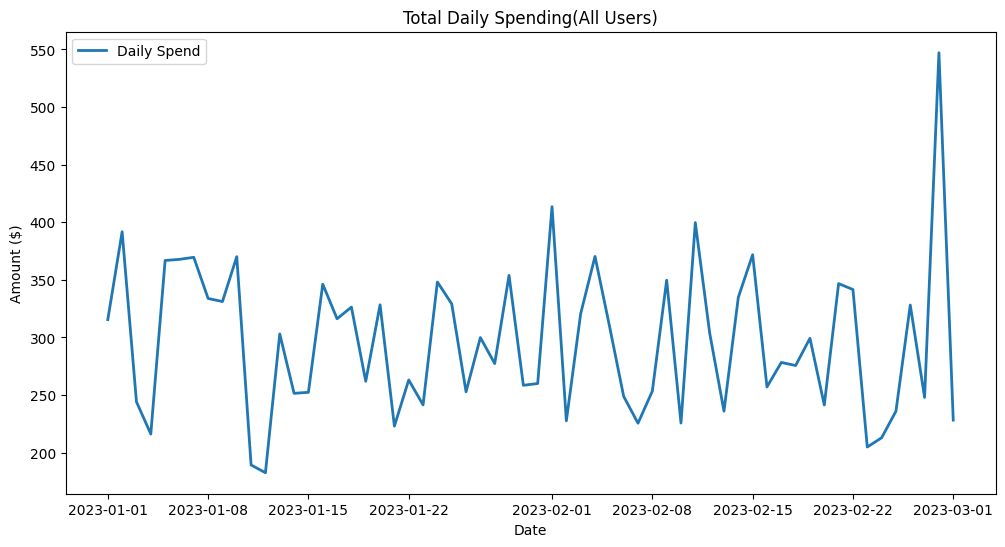

In [ ]:
#Group by transaction date
daily_spend= df.groupby("date")["amount"].sum()

#plot daily spending trend
plt.figure(figsize=(12,6))
plt.plot(daily_spend.index, daily_spend.values, label="Daily Spend", linewidth=2)
plt.title("Total Daily Spending(All Users)")
plt.xlabel("Date")
plt.ylabel("Amount ($)")
plt.legend()
plt.show()

Detect Anomalies

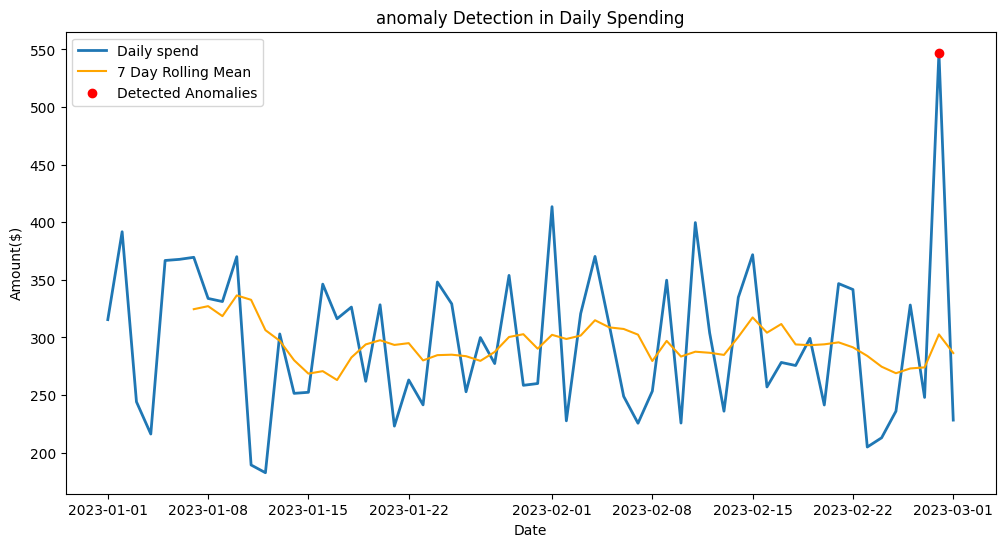

In [ ]:
# compute rolling stats (7 days windows)
rolling_mean= daily_spend.rolling(window=7).mean()
rolling_std= daily_spend.rolling(window=7).std()

#Detect Anomalies
anomalies= daily_spend[ daily_spend> rolling_mean +2 * rolling_std]

#plot
plt.figure(figsize=(12,6))
plt.plot(daily_spend.index, daily_spend.values, label="Daily spend" , linewidth=2)
plt.plot(rolling_mean.index, rolling_mean.values, label="7 Day Rolling Mean", color= "orange")
plt.scatter(anomalies.index, anomalies.values, color= "red", label="Detected Anomalies", zorder=5)
plt.title("anomaly Detection in Daily Spending")
plt.xlabel("Date")
plt.ylabel("Amount($)")
plt.legend()
plt.show()



Fraud Label Comparision

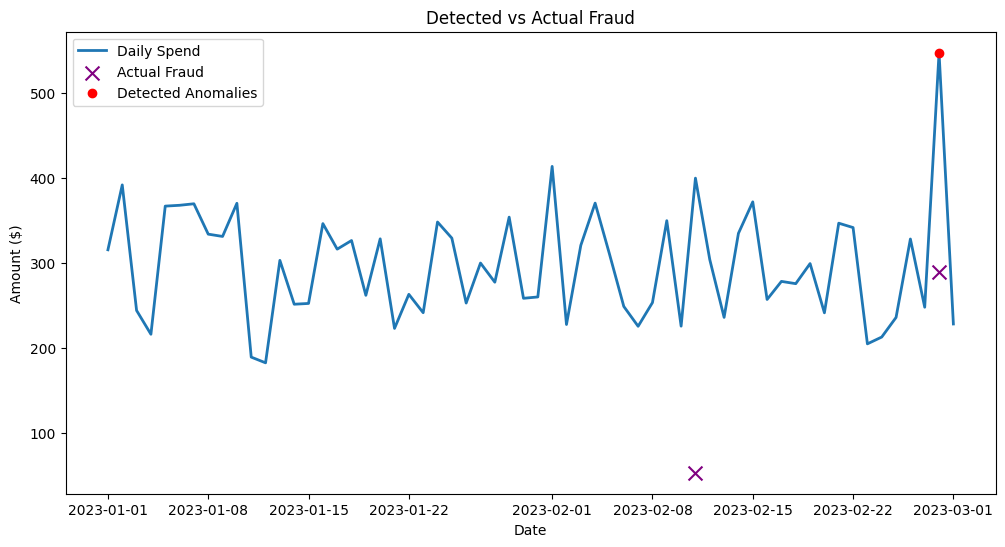

In [ ]:
# Aggregate fraud transactions by day
fraud_days = df[df["is_fraud"]==1].groupby("date")["amount"].sum()

# Plot daily spend
plt.figure(figsize=(12,6))
plt.plot(daily_spend.index, daily_spend.values, label="Daily Spend", linewidth=2)

# Mark actual fraud days (purple X)
plt.scatter(fraud_days.index, fraud_days.values, color="purple", marker="x", s=100, label="Actual Fraud")

# Mark detected anomalies (red dots)
plt.scatter(anomalies.index, anomalies.values, color="red", label="Detected Anomalies", zorder=5)

plt.title("Detected vs Actual Fraud")
plt.xlabel("Date")
plt.ylabel("Amount ($)")
plt.legend()
plt.show()


Setup Pytorch

In [ ]:
!pip install torch

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

Prapare Time-Series Data

In [ ]:
#use daily spending series
values = daily_spend.values.reshape(-1,1)

#normalize (import for LSTM stability)
from sklearn.preprocessing import MinMaxScaler
scaler= MinMaxScaler()
values_scaled= scaler.fit_transform(values)

#function to create sequence
def create_sequences(data, seq_length=7):
   xs, ys = [], []
   for i in range(len(data)-seq_length):
       x= data[i:i+seq_length]
       y= data[i+seq_length]
       xs.append(x)
       ys.append(y)
   return np.array(xs), np.array(ys)


SEQ_LEN= 7
X,y= create_sequences(values_scaled, SEQ_LEN)

X_tensor= torch.tensor(X, dtype=torch.float32)
y_tensor= torch.tensor(y, dtype=torch.float32)

dataset= TensorDataset(X_tensor,y_tensor)
train_loader= DataLoader(dataset, batch_size=16, shuffle=True)

Build LSTM Autoencoder

In [ ]:
class LSTMAutoencoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=32):
        super(LSTMAutoencoder, self).__init__()
        self.seq_len = seq_len
        self.n_features = n_features
        self.embedding_dim = embedding_dim

        # Encoder
        self.encoder = nn.LSTM(
            input_size=n_features, hidden_size=embedding_dim, batch_first=True
        )
        # Decoder
        self.decoder = nn.LSTM(
            input_size=embedding_dim, hidden_size=n_features, batch_first=True
        )

    def forward(self, x):
        # Encode
        _, (hidden, _) = self.encoder(x)
        # Repeat hidden for seq_len steps
        hidden_repeated = hidden.repeat(self.seq_len, 1, 1).permute(1,0,2)
        # Decode
        decoded, _ = self.decoder(hidden_repeated)
        return decoded


Train the Model

In [ ]:
model = LSTMAutoencoder(seq_len=SEQ_LEN, n_features=1, embedding_dim=16)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

EPOCHS = 20
for epoch in range(EPOCHS):
    losses = []
    for batch in train_loader:
        X_batch, _ = batch
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, X_batch)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {np.mean(losses):.4f}")

Epoch 1/20, Loss: 0.2933
Epoch 2/20, Loss: 0.2885
Epoch 3/20, Loss: 0.2639
Epoch 4/20, Loss: 0.2521
Epoch 5/20, Loss: 0.2336
Epoch 6/20, Loss: 0.2229
Epoch 7/20, Loss: 0.2050
Epoch 8/20, Loss: 0.1885
Epoch 9/20, Loss: 0.1801
Epoch 10/20, Loss: 0.1639
Epoch 11/20, Loss: 0.1466
Epoch 12/20, Loss: 0.1287
Epoch 13/20, Loss: 0.1174
Epoch 14/20, Loss: 0.1055
Epoch 15/20, Loss: 0.0964
Epoch 16/20, Loss: 0.0858
Epoch 17/20, Loss: 0.0852
Epoch 18/20, Loss: 0.0799
Epoch 19/20, Loss: 0.0739
Epoch 20/20, Loss: 0.0742


Detect Anomalies

In [ ]:
# Reconstruct full sequence
model.eval()
with torch.no_grad():
    recon = model(X_tensor).numpy()

# Compute reconstruction error
recon_error = np.mean((X - recon)**2, axis=(1,2))

# Threshold = mean + 2*std
threshold = np.mean(recon_error) + 2*np.std(recon_error)
anomaly_indices = np.where(recon_error > threshold)[0]

# Map anomalies back to dates
anomaly_dates = daily_spend.index[SEQ_LEN:][anomaly_indices]


Plot LSTM Results

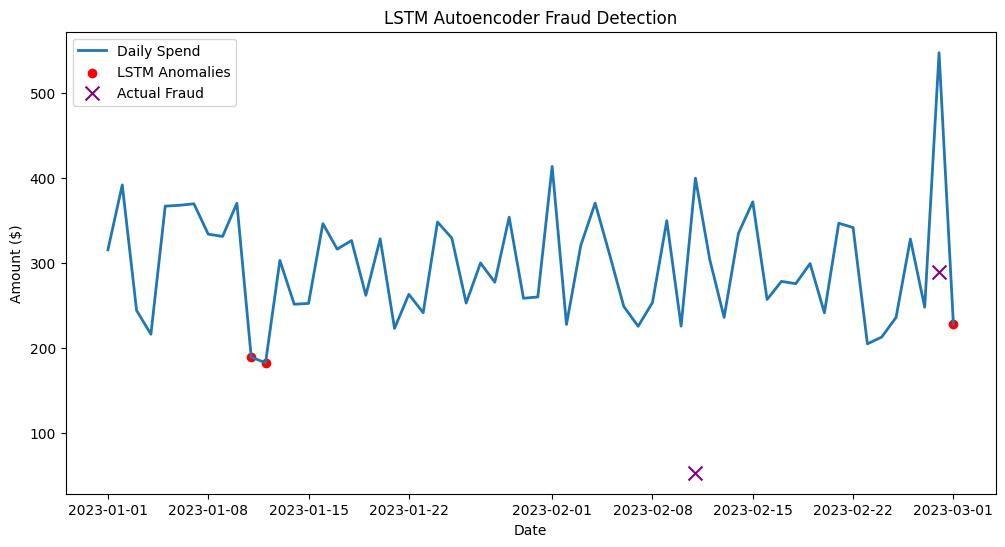

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(daily_spend.index, daily_spend.values, label="Daily Spend", linewidth=2)
plt.scatter(anomaly_dates, daily_spend.loc[anomaly_dates], color="red", label="LSTM Anomalies")
plt.scatter(fraud_days.index, fraud_days.values, color="purple", marker="x", s=100, label="Actual Fraud")
plt.title("LSTM Autoencoder Fraud Detection")
plt.xlabel("Date")
plt.ylabel("Amount ($)")
plt.legend()
plt.show()
